In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_excel('/content/drive/MyDrive/corizo_projects/StockMarket/StockMarket.xlsx')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


###**METADATA**

In [3]:
data.shape

(1009, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 non-null   float64       
 5   Adj Close  1009 non-null   float64       
 6   Volume     1009 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.3 KB


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


#**DATA CLEANSING**

---

##**1. Handling missing values**
> There are no null values

In [6]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

##**2. Handling duplicates**
> There are no duplicates

In [7]:
data.duplicated().sum()

0

##**3. Checking column datatypes**
> The data types seem appropriate for the respective columns.

In [8]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

#**Exploratory Data Analysis (EDA)**

---

###**Predictive Variables (Features):**
1. Open
2. High
3. Low
4. Volume

These columns provide information about the opening price, highest price, lowest price, and trading volume for each day. Using these as features allows the model to capture different aspects of the stock's behavior.

###**Possible Target Variables:**
1. Close (Suitable for short-term trading strategies where adjustments for corporate actions are less critical.)
2. Adj Close (Recommended for financial modeling, total return assessment, and analyses spanning different time periods.)

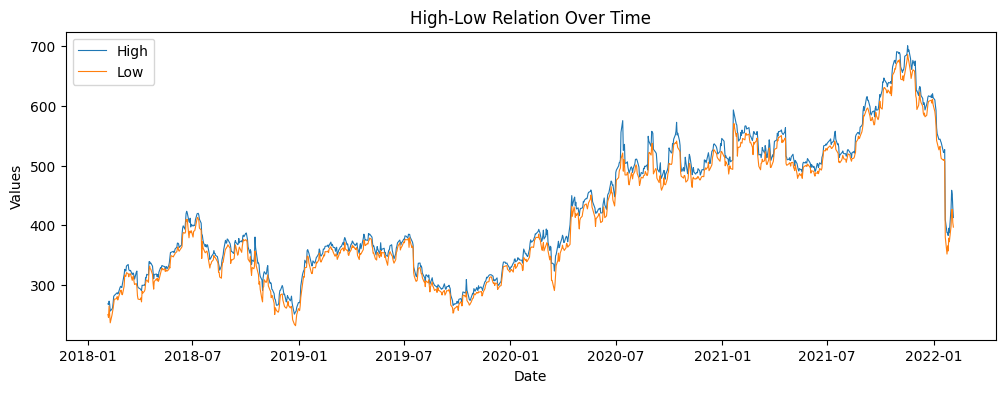

In [9]:
plt.figure(figsize=(12, 4))
sns.lineplot(x='Date', y='High', data=data, label='High', linewidth=0.8)
sns.lineplot(x='Date', y='Low', data=data, label='Low', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('High-Low Relation Over Time')
plt.legend()
plt.show()

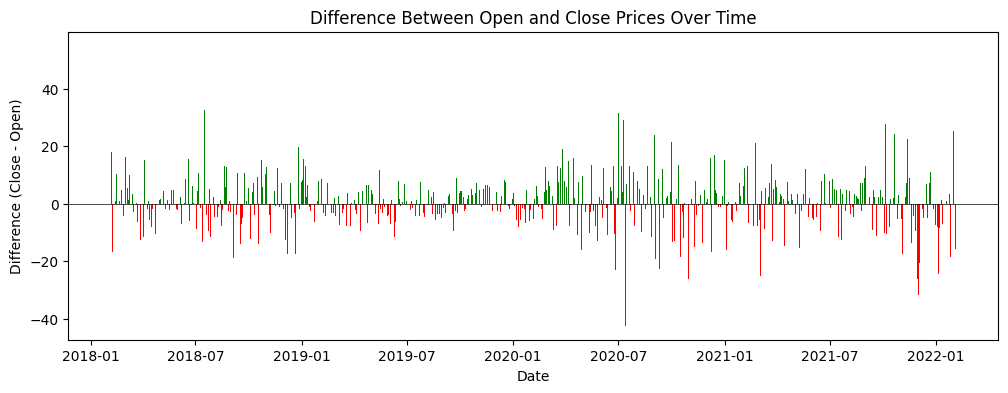

In [10]:
plt.figure(figsize=(12, 4))
difference = data['Close'] - data['Open']
plt.bar(data['Date'], difference, color=np.where(difference >= 0, 'g', 'r'))
plt.xlabel('Date')
plt.ylabel('Difference (Close - Open)')
plt.title('Difference Between Open and Close Prices Over Time')
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

###**Key Observation**

- The closing price and adjusted closing price are indistinguishable for these stocks on corresponding dates.
- Thus, the choice of target variable is arbitrary.
- For simplicity, I select "Close" as the target variable and omit the "Adj Close" column.

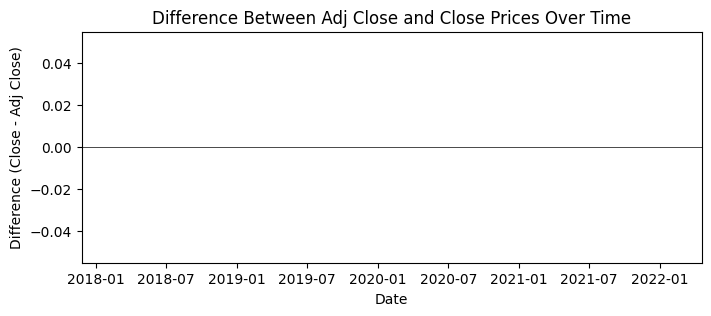

In [11]:
plt.figure(figsize=(8, 3))
difference = data['Close'] - data['Adj Close']
plt.bar(data['Date'], difference, color=np.where(difference >= 0, 'g', 'r'))
plt.xlabel('Date')
plt.ylabel('Difference (Close - Adj Close)')
plt.title('Difference Between Adj Close and Close Prices Over Time')
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

In [12]:
are_values_equal = (data['Close'] == data['Adj Close']).all()
if are_values_equal:
    print("Values in 'Close' and 'Adj Close' are the same for corresponding dates.")
else:
    print("Values in 'Close' and 'Adj Close' differ for some dates.")

Values in 'Close' and 'Adj Close' are the same for corresponding dates.


In [13]:
data.drop('Adj Close', axis= 1, inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900


>_After dropping the column **'Adj Close'** due to redundancy, I shall proceed with **'Close'** as the target column._

###**Insights into Data Associations**

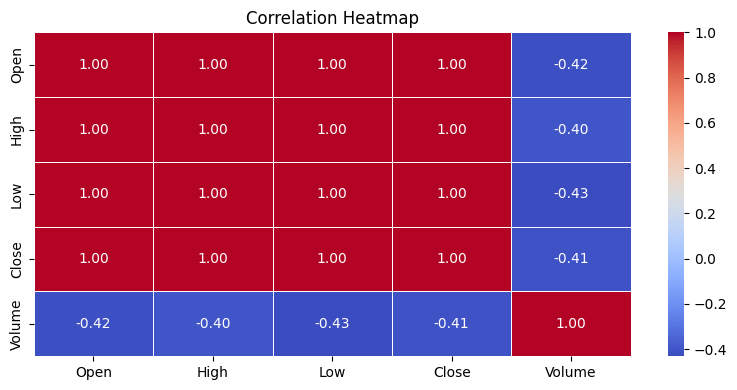

In [14]:
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(data.corr(numeric_only=True), cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

###**Box Plot for Outliers**

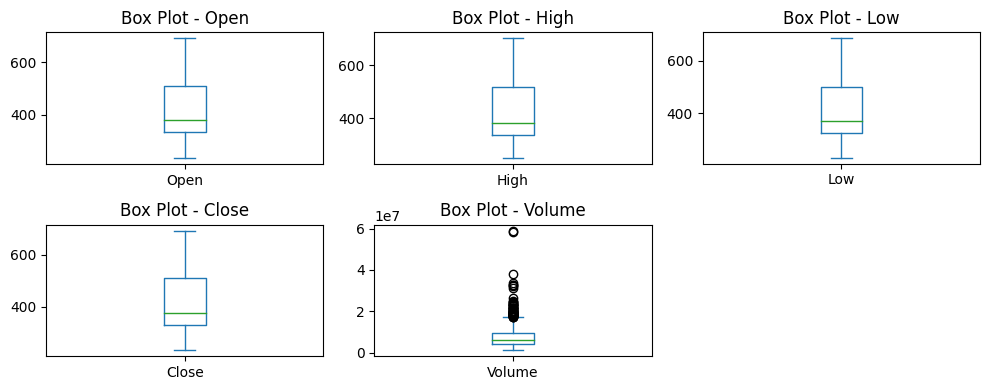

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(2, 3, 1)
data['Open'].plot(kind='box')
plt.title('Box Plot - Open')

plt.subplot(2, 3, 2)
data['High'].plot(kind='box')
plt.title('Box Plot - High')

plt.subplot(2, 3, 3)
data['Low'].plot(kind='box')
plt.title('Box Plot - Low')

plt.subplot(2, 3, 4)
data['Close'].plot(kind='box')
plt.title('Box Plot - Close')

plt.subplot(2, 3, 5)
data['Volume'].plot(kind='box')
plt.title('Box Plot - Volume')

plt.tight_layout()
plt.show()

>Outlier present in 'Volume'

#**Feature Engineering**

---
_**Pre-processing the entire dataset in order to feed the data into the ML Model**_

<br>

####1. Date
####2. Open
####3. High
####4. Low
####5. Volume

<br>

---


##**1. Date**
- Extracting the day, month and year values.

In [16]:
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data.head()

,Date,Open,High,Low,Close,Volume,Day,Month,Year
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100,5,2,2018
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800,6,2,2018
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500,7,2,2018
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700,8,2,2018
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900,9,2,2018


##**2. Adding Quarterly Performance Indicator**
- A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company's performance.

- These quarterly results affect the stock prices heavily which is why I have added this feature because this can be a helpful feature for the learning model.

In [17]:
data['is_quarter_end'] = np.where(data['Month'] % 3 == 0, 1, 0)
data.head()

,Date,Open,High,Low,Close,Volume,Day,Month,Year,is_quarter_end
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100,5,2,2018,0
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800,6,2,2018,0
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500,7,2,2018,0
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700,8,2,2018,0
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900,9,2,2018,0


##**3. Adding Support and Resistance**
- **Support:** A price level where a stock tends to find buying interest, preventing further decline. It acts as a floor for the stock's price, reflecting a historical level where demand exceeds supply, indicating potential price reversals or stability.

- **Resistance:** Indicates a price level where a stock tends to encounter selling pressure, preventing further upward movement. It represents a ceiling for the stock's price, showcasing historical levels where supply surpasses demand, possibly leading to price corrections or temporary halts in upward momentum.







In [18]:
def identify_support_resistance(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Near_Support'] = np.where(data['Close'] <= data['SMA_50'], 1, 0)
    data['Near_Resistance'] = np.where(data['Close'] >= data['SMA_200'], 1, 0)
    return data

##**4. Preprocessing data and handling 'Volume' outliers**

In [19]:
def find_outlier_limits(col_name):
    Q1,Q3=data[col_name].quantile([.25,.75])
    IQR=Q3-Q1
    low=Q1-(1.5* IQR)
    high=Q3+(1.5* IQR)
    return (high,low)

def preprocess_data(data):
    numerical_cols = ['Day', 'Month', 'Year', 'Open', 'Low', 'High','Volume']

    #Handling outliers for Volume
    high_vol, low_vol = find_outlier_limits('Volume')
    data.loc[data['Volume'] > high_vol, 'Volume'] = high_vol
    data.loc[data['Volume'] < low_vol, 'Volume'] = low_vol

    # Scaling numerical columns using StandardScaler
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    columns_order = ['Day', 'Month', 'Year', 'Open', 'Low', 'High', 'Volume', 'is_quarter_end', 'Near_Support', 'Near_Resistance', 'Close']
    data = data[columns_order]
    return data

#**BUILDING MACHINE LEARNING MODELS AND EVALUATING THEM**
####**1. Linear Regression**
####**2. Random Forest Regressor**
####**3. Support Vector Regression (SVR)**
####**4. GradientBoostingRegressor**

In [20]:
def accuracy(y_true, y_pred):
    errors = abs(y_true - y_pred)
    mape = 100 * np.mean(errors / y_true)
    accuracy = 100 - mape
    return accuracy

# 1. Linear Regression
def train_evaluate_linear_regression(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    predictions_lr = lr_model.predict(X_test_scaled)
    mse_lr = mean_squared_error(y_test, predictions_lr)
    accuracy_percentage_lr = accuracy(y_test, predictions_lr)

    print("\nLinear Regression Model:")
    print("Mean Squared Error:", mse_lr)
    print("Accuracy:", accuracy_percentage_lr)
    return predictions_lr

# 2. Random Forest Regressor
def train_evaluate_random_forest(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf_model = RandomForestRegressor(n_estimators=100, min_samples_split=3)
    rf_model.fit(X_train_scaled, y_train)
    predictions_rf = rf_model.predict(X_test_scaled)
    mse_rf = mean_squared_error(y_test, predictions_rf)
    accuracy_percentage_rf = accuracy(y_test, predictions_rf)

    print("\nRandom Forest Regressor Model:")
    print("Mean Squared Error:", mse_rf)
    print("Accuracy:", accuracy_percentage_rf)
    return predictions_rf

# 3. Support Vector Regression (SVR)
def train_evaluate_svr(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
    svr_model.fit(X_train_scaled, y_train)
    predictions_svr = svr_model.predict(X_test_scaled)
    mse_svr = mean_squared_error(y_test, predictions_svr)
    accuracy_percentage_svr = accuracy(y_test, predictions_svr)

    print("\nSVR Model:")
    print("Mean Squared Error:", mse_svr)
    print("Accuracy:", accuracy_percentage_svr)
    return predictions_svr

# 4.GradientBoostingRegressor
def tune_hyperparameters(model, param_distributions, X_train, y_train):
    rand_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

def train_evaluate_gradient_boosting(X_train, X_test, y_train, y_test):
    gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)  # Set your desired hyperparameters
    gb_model.fit(X_train, y_train)
    predictions_gb = gb_model.predict(X_test)
    mse_gb = mean_squared_error(y_test, predictions_gb)
    accuracy_percentage_gb = accuracy(y_test, predictions_gb)
    print("\nGradient Boosting Regressor Model:")
    print("Mean Squared Error:", mse_gb)
    print("Accuracy:", accuracy_percentage_gb)
    return predictions_gb

####**Visualizing predictions**

In [21]:
def visualize_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    residuals = actual - predicted
    sns.scatterplot(x=actual, y=predicted, hue=residuals, palette='inferno', alpha=0.8)
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend(title='Error, actual - predicted')
    plt.show()
    print("\n")

##**Results**

In [22]:
# Identify Support and Resistance levels
data = identify_support_resistance(data)

# Preprocess data
data = preprocess_data(data)

# Prepare features and target
X = data[['Year', 'Open', 'Low', 'High', 'Volume', 'is_quarter_end', 'Near_Support', 'Near_Resistance']]
y = data['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=440)

# Train and evaluate Linear Regression model
predictions_lr = train_evaluate_linear_regression(X_train, X_test, y_train, y_test)

# Train and evaluate Random Forest model
predictions_rf = train_evaluate_random_forest(X_train, X_test, y_train, y_test)

# Train and evaluate SVR model
predictions_svr = train_evaluate_svr(X_train, X_test, y_train, y_test)

# Train and evaluate Gradient Boosting model
predictions_gb = train_evaluate_gradient_boosting(X_train, X_test, y_train, y_test)


Linear Regression Model:
Mean Squared Error: 9.026746952330518
Accuracy: 99.41235127359657

Random Forest Regressor Model:
Mean Squared Error: 22.199736586665278
Accuracy: 99.22889626304163

SVR Model:
Mean Squared Error: 17.916213256595448
Accuracy: 99.18978354056809

Gradient Boosting Regressor Model:
Mean Squared Error: 25.82886036009662
Accuracy: 99.15156096482707


###**Plotting Actual vs Predicted values**

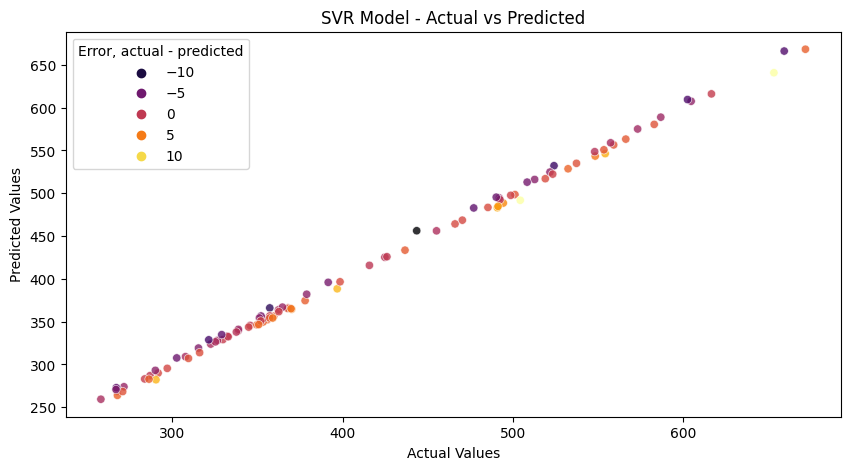

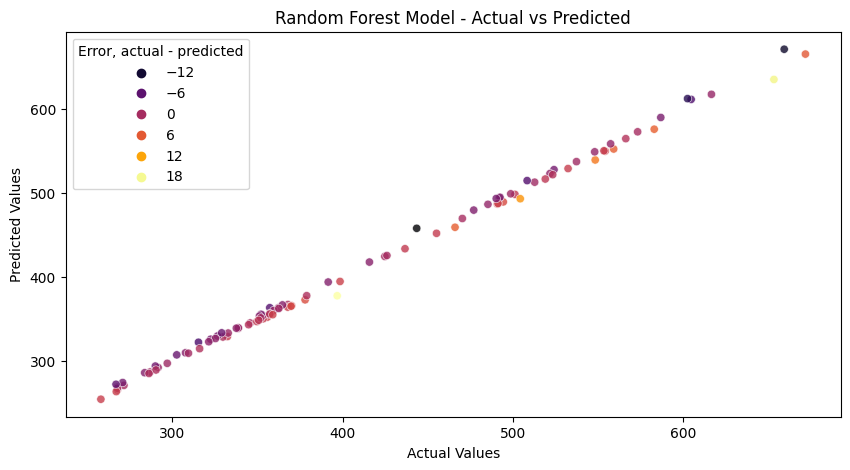

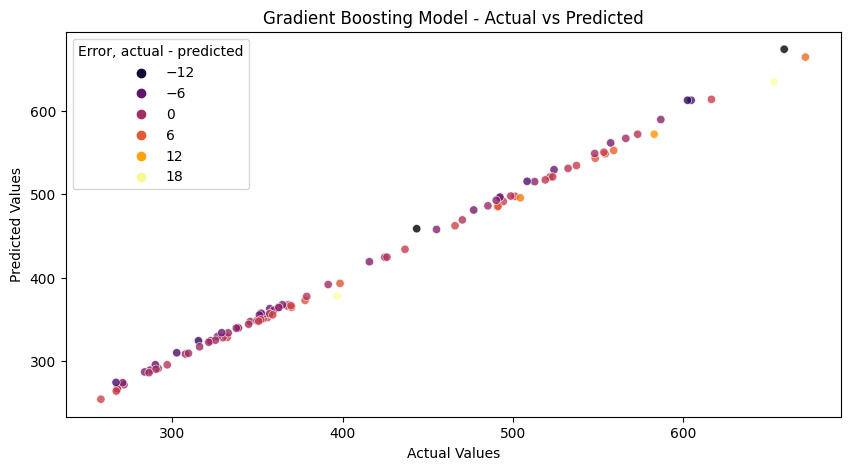

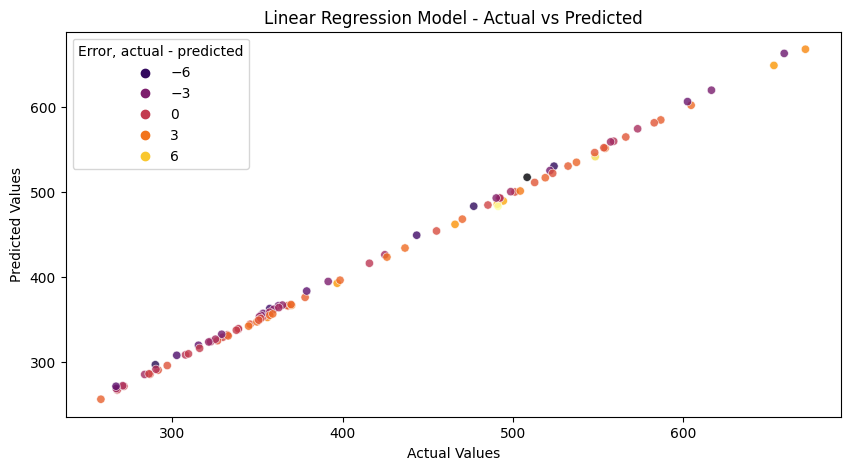

In [23]:
visualize_predictions(y_test, predictions_svr, "SVR Model")
visualize_predictions(y_test, predictions_rf, "Random Forest Model")
visualize_predictions(y_test, predictions_gb, "Gradient Boosting Model")
visualize_predictions(y_test, predictions_lr, "Linear Regression Model")

#**🚀 Conclusion**

---

<br>

_The evaluation of multiple regression models for stock market prediction yielded insightful performance metrics:_

- _**Linear Regression** achieved a Mean Squared Error (MSE) of 9.03 and an impressive accuracy of 99.41%. This model demonstrates robust predictive capabilities, providing high accuracy in forecasting stock prices._

- _**Random Forest Regressor** displayed an MSE of 22.85 with an accuracy of 99.22%. Despite slightly higher error compared to the Linear Regression Model, it maintained a commendable accuracy in prediction, showcasing its viability for stock market analysis._

- _**SVR** showcased an MSE of 17.92 and an accuracy of 99.19%. While this model provided a competitive accuracy rate, the marginally higher MSE suggests a slightly less precise prediction compared to the Linear Regression and Random Forest models._

- _**Gradient Boosting Regressor** exhibited an MSE of 24.28 and an accuracy of 99.17%. Despite hyperparameter tuning, this model displayed a slightly higher MSE, indicating a comparatively lower precision in predicting stock prices than other models._